In [1]:
import numpy as np
from data import Instance, DataSet
from miscellaneous import initialize_data, plot_graph, plot_points
from neural_network import NeuralNetwork
from activation_function import *
import matplotlib.pyplot as plt
from keras.datasets import mnist
import pandas as pd
import copy
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


#### Carregando dados e Ajustando labels

In [2]:
# Carregando dados
train = pd.read_csv('../dataset/train.csv')
test = pd.read_csv('../dataset/test.csv')

# Ajustando nomes
train_labels = [i.lower() for i in train.columns.values]
test_labels = [i.lower() for i in test.columns.values]

rename_dict_train = { i: j for i,j in zip(train.columns.values, train_labels) }
rename_dict_test = { i: j for i,j in zip(test.columns.values, test_labels) }

train.rename(columns = rename_dict_train, inplace = True)
test.rename(columns = rename_dict_test, inplace = True)

#### Selecionando atributos relevantes

In [3]:
train = train.filter(['pclass', 'sex', 'age', 'fare', 'cabin', 'embarked', 'survived'], axis = 1)
test = test.filter(['pclass', 'sex', 'age', 'fare', 'cabin', 'embarked', 'survived'], axis = 1)

##### Age

In [4]:
train['age'].fillna(train['age'].median(), inplace = True)
test['age'].fillna(test['age'].median(), inplace = True)

##### Sex

In [5]:
binarizer = LabelBinarizer()
train['sex'] = binarizer.fit_transform(train['sex'])
test['sex'] = binarizer.fit_transform(test['sex'])

##### Fare

In [6]:
train['fare'].fillna(train['fare'].median(), inplace = True)
test['fare'].fillna(test['fare'].median(), inplace = True)

##### Embarked

In [7]:
train['embarked'].fillna(str(train['embarked'].mode()), inplace = True)
test['embarked'].fillna(str(test['embarked'].mode()), inplace = True)

encoder = LabelEncoder()
train['embarked'] = encoder.fit_transform(train['embarked'])
test['embarked'] = encoder.fit_transform(test['embarked'])

##### Cabin

In [8]:
train.loc[train['cabin'].notnull(), 'cabin'] = train['cabin'].str[0]
train['cabin'].fillna('H', inplace = True)

test.loc[test['cabin'].notnull(), 'cabin'] = test['cabin'].str[0]
test['cabin'].fillna('H', inplace = True)

train['cabin'] = encoder.fit_transform(train['cabin'])
test['cabin'] = encoder.fit_transform(test['cabin'])

##### Remoção de Outliers

In [9]:
for c1, c2 in zip(train, test):
    train[c1][~(np.abs(train[c1]-train[c1].mean())>(3*train[c1].std()))]
    test[c2][~(np.abs(test[c2]-test[c2].mean())>(3*test[c2].std()))]

##### Normalização

In [10]:
min_max_s = MinMaxScaler(feature_range = (0.0, 1.0))

for c1, c2 in zip(train, test):
    train[c1] = min_max_s.fit_transform(train[c1].values.reshape(-1, 1))
    test[c2] = min_max_s.fit_transform(test[c2].values.reshape(-1, 1))

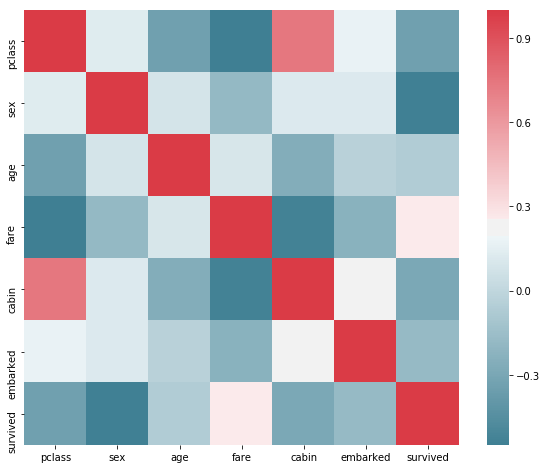

In [11]:
corr = train.corr()

f, ax = plt.subplots(figsize = (10, 8))
sns.heatmap(corr, mask = np.zeros_like(corr, dtype = np.bool), cmap = sns.diverging_palette(220, 10, as_cmap = True),
            square = True, ax = ax)

In [12]:
if 'cabin' in train:
    train.drop(['cabin'], axis = 1, inplace = True)

if 'cabin' in test:
    test.drop(['cabin'], axis = 1, inplace = True)

In [13]:
x_train = train.filter(['pclass', 'sex', 'age', 'fare', 'embarked'], axis = 1)
y_train = train.filter(['survived'], axis = 1)

x_train_list = x_train.values.tolist()

y_train_list = []
for i in y_train.values.tolist():
    if(i[0] >= 0.5):
        y_train_list.append([1.0, 0.0])
    else:
        y_train_list.append([0.0, 1.0])
        
dataset = DataSet() 
for inst_x, inst_y in zip(x_train_list, y_train_list):
    dataset.add(Instance(inst_x, inst_y))

In [ ]:
net = NeuralNetwork(5, [30, 10, 2], 4*[sig_func])
data = net.fit(dataset, "mini-batch", 500, lr_ = 0.1, type = "class", mini_batch_size = 20, 
                   tvt_ratio = [8, 2, 0], momentum_ = 0.8, print_info = True)

In [50]:
n_split = 10
kfold = StratifiedKFold(n_splits = n_split, shuffle = True, random_state = 11403723)

i = 1
data_cv_mean = [0, 0, 0]
for a, b in kfold.split(x_train, y_train):
    
    print("\rTraining fold: ", i)
    i += 1
    dataset = None
    dataset = DataSet()
    
    for ind in a:
        dataset.add(Instance(x_train_list[ind], y_train_list[ind]))
    
    for ind in b:
        dataset.add(Instance(x_train_list[ind], y_train_list[ind]))

    net_cv = NeuralNetwork(5, [30, 10, 2], 4*[sig_func])
    data_cv = net_cv.fit(dataset, "mini-batch", 100, lr_ = 0.1, type = "class", mini_batch_size = 20, 
                      tvt_ratio = [9, 1, 0], momentum_ = 0.8, print_info = False)   
    
    if data_cv_mean[0] == 0:
        data_cv_mean = data_cv.copy()
    else:
        data_cv_mean[1] = [ i+j for i, j in zip(data_cv_mean[1], data_cv[1]) ]
        data_cv_mean[2] = [ i+j for i, j in zip(data_cv_mean[2], data_cv[2]) ]

data_cv_mean[1] = [ elem/n_split for elem in data_cv_mean[1]]
data_cv_mean[2] = [ elem/n_split for elem in data_cv_mean[2]]

Training fold:  1
Training fold:  2
Training fold:  3
Training fold:  4
Training fold:  5
Training fold:  6
Training fold:  7
Training fold:  8
Training fold:  9
Training fold:  10


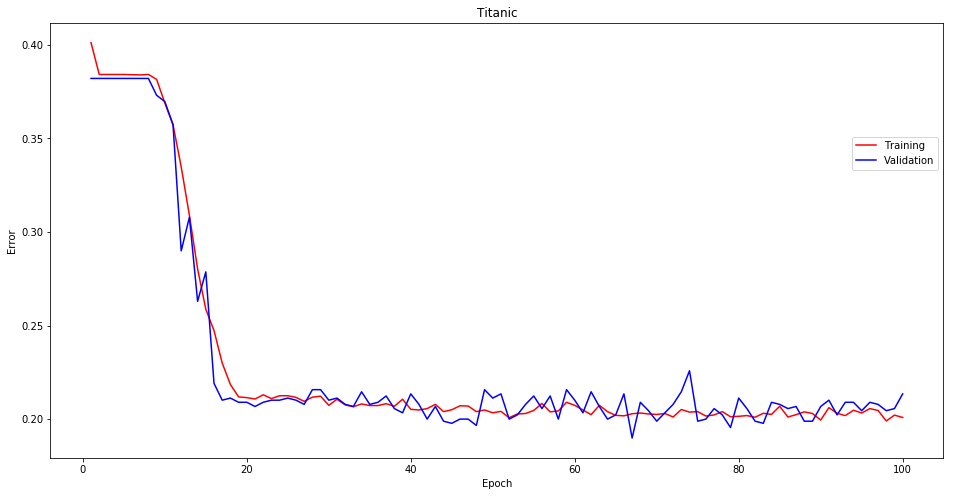

In [51]:
plot_graph(data_cv_mean, "Titanic", "Epoch", "Error", figsizex = 16, figsizey = 8)